# Introduction: Bayesian Linear Regression Project

Source: https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb

In this notebook, we will implement a complete machine learning project, focusing on Bayesian Inference methods, in particular, Bayesian Linear Regression. We will go through the entire machine learning process, cleaning the data, exploring it to find trends, establishing a baseline model, evaluating several machine learning approaches for comparisons, implementing Bayesian Linear Regression, interpreting the results, and presenting the results. Let's get started!

## Dataset

We are using data on student grades collected from a Portuguese secondary (high) school. This data is from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/student+performance#), a great collection of datasets for model testing. The data includes academic and personal characteristics of the students as well as final grades. The objective is to predict the final grade from the student information which makes this a __supervised, regression task__. We have a set of training data with known labels, and we want the model to learn a mapping from the features (explanatory variables) to the target (the label) in this case the final grade. It is a regression task because the final grade is a continuous value.

# Exploratory Data Analysis

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [2]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [3]:
# PyMC3 for Bayesian Inference
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import pymc3 as pm

/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read in Data and Examine

In [5]:
# Read in class scores
df = pd.read_csv('data/student-mat.csv')

# Filter out grades that were 0
df = df[~df['G3'].isin([0, 1])]

df = df.rename(columns={'G3': 'Grade'})

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [6]:
df.shape

(633, 33)

### Describe for Numerical Columns

In [7]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,16.720379,2.519747,2.320695,1.563981,1.941548,0.206951,3.932070,3.169036,3.184834,1.489731,2.268562,3.527646,3.751975,11.503949,11.756714,12.205371
std,1.214044,1.133497,1.102284,0.750167,0.833284,0.579023,0.946411,1.047082,1.162014,0.912452,1.281776,1.448355,4.662003,2.682645,2.629715,2.656882
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,5.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,12.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


### Value Counts for Categorical Columns

In [8]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: school
GP    421
MS    212
Name: school, dtype: int64

Column Name: sex
F    376
M    257
Name: sex, dtype: int64

Column Name: address
U    446
R    187
Name: address, dtype: int64

Column Name: famsize
GT3    443
LE3    190
Name: famsize, dtype: int64

Column Name: Pstatus
T    555
A     78
Name: Pstatus, dtype: int64

Column Name: Mjob
other       249
services    135
at_home     131
teacher      70
health       48
Name: Mjob, dtype: int64

Column Name: Fjob
other       359
services    175
at_home      41
teacher      35
health       23
Name: Fjob, dtype: int64

Column Name: reason
course        279
home          146
reputation    141
other          67
Name: reason, dtype: int64

Column Name: guardian
mother    444
father    149
other      40
Name: guardian, dtype: int64

Column Name: schoolsup
no     566
yes     67
Name: schoolsup, dtype: int64

Column Name: famsup
yes    393
no     240
Name: famsup, dtype: int64

Column Name: paid
no     595
yes     38
Name: paid, dty

### Distribution of Grades

In [9]:
df['Grade'].describe()

count    633.000000
mean      12.205371
std        2.656882
min        5.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: Grade, dtype: float64

In [10]:
df['Grade'].value_counts()

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
7      10
6       3
19      2
5       1
Name: Grade, dtype: int64

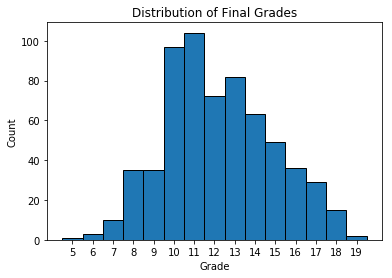

In [11]:
# Bar plot of grades
plt.bar(df['Grade'].value_counts().index, 
        df['Grade'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Final Grades');
plt.xticks(list(range(5, 20)));

#### Grade Distribution by Different Categorical Variables

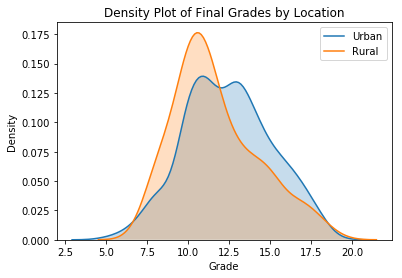

In [14]:
# Grade distribution by address
sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Location');

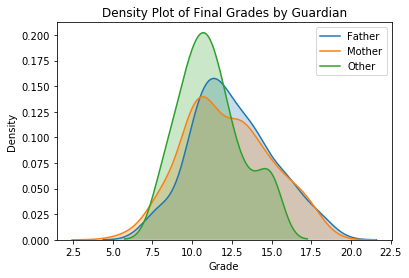

In [15]:
# Grade distribution by Guardian
sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Guardian');

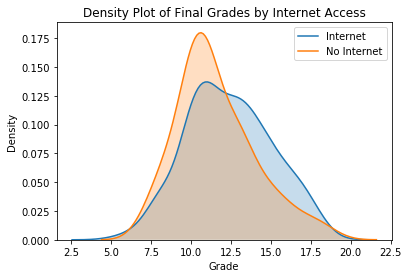

In [16]:
# Grade distribution by internet
sns.kdeplot(df.loc[df['internet'] == 'yes', 'Grade'], label = 'Internet', shade = True)
sns.kdeplot(df.loc[df['internet'] == 'no', 'Grade'], label = 'No Internet', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Internet Access');

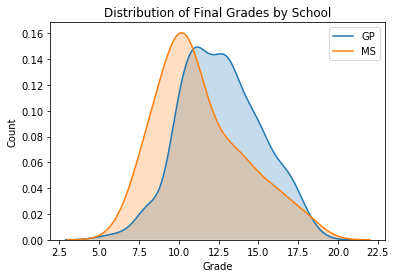

In [17]:
# Grade distribution by school
sns.kdeplot(df.loc[df['school'] == 'GP', 'Grade'], label = 'GP', shade = True)
sns.kdeplot(df.loc[df['school'] == 'MS', 'Grade'], label = 'MS', shade = True)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Final Grades by School');

In [18]:
# Look at distribution of schools by address
schools = df.groupby(['school'])['address'].value_counts()
schools

school  address
GP      U          343
        R           78
MS      R          109
        U          103
Name: address, dtype: int64

### Grade Percentiles

In [19]:
# Calculate percentile for grades
df['percentile'] = df['Grade'].apply(lambda x: percentileofscore(df['Grade'], x))

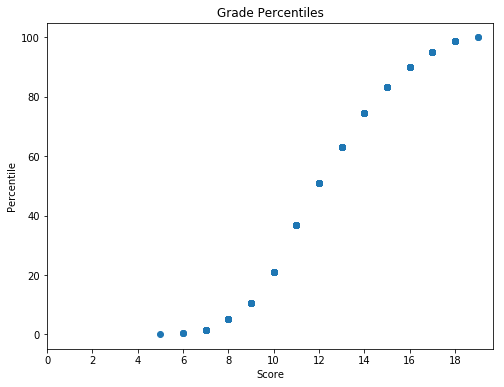

In [20]:
# Plot percentiles for grades
plt.figure(figsize = (8, 6))
plt.plot(df['Grade'], df['percentile'], 'o')
plt.xticks(range(0, 20, 2), range(0, 20, 2))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Grade Percentiles');

In [21]:
print('50th percentile score:', np.min(df.loc[df['percentile'] > 50, 'Grade']))
print('Minimum Score needed for 90th percentile:', np.min(df.loc[df['percentile'] > 90, 'Grade']))

50th percentile score: 12
Minimum Score needed for 90th percentile: 17


# Variable Correlations with Final Grade

## Numerical Correlations

In [22]:
# Correlations of numerical values
df.corr()['Grade'].sort_values()

failures     -0.384569
absences     -0.204230
Dalc         -0.196891
Walc         -0.178839
traveltime   -0.129654
goout        -0.111228
freetime     -0.105206
health       -0.096461
age          -0.042505
famrel        0.072888
Fedu          0.204392
studytime     0.249855
Medu          0.278690
G1            0.874777
G2            0.942691
percentile    0.985253
Grade         1.000000
Name: Grade, dtype: float64

## Categorical Correlations using One-Hot Encoding

In [23]:
# Select only categorical variables
category_df = df.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
# Put the grade back in the dataframe
dummy_df['Grade'] = df['Grade']
dummy_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,1,1,0,1,0,11
1,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,1,0,1,1,0,11
2,1,0,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,1,1,0,12
3,1,0,1,0,0,1,1,0,0,1,...,1,0,1,0,1,0,1,0,1,14
4,1,0,1,0,0,1,1,0,0,1,...,0,0,1,0,1,1,0,1,0,13


In [24]:
# Correlations in one-hot encoded dataframe
dummy_df.corr()['Grade'].sort_values()

higher_no           -0.343742
school_MS           -0.227632
Mjob_at_home        -0.158496
reason_course       -0.138195
internet_no         -0.131408
address_R           -0.128350
sex_M               -0.125755
guardian_other      -0.100802
schoolsup_yes       -0.098185
reason_other        -0.092382
activities_no       -0.078526
paid_yes            -0.067146
nursery_no          -0.056449
romantic_yes        -0.052050
Fjob_at_home        -0.049372
Fjob_services       -0.042497
Mjob_other          -0.035494
Fjob_other          -0.021292
famsize_GT3         -0.012957
guardian_mother     -0.008042
Pstatus_T           -0.001776
famsup_no           -0.001581
famsup_yes           0.001581
Pstatus_A            0.001776
Mjob_services        0.006210
famsize_LE3          0.012957
Fjob_health          0.026320
reason_home          0.046639
romantic_no          0.052050
nursery_yes          0.056449
guardian_father      0.066486
paid_no              0.067146
activities_yes       0.078526
Mjob_healt

# Select 5 Most Correlated Variables with Final Score

In [25]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df):
    # Targets are final grade of student
    labels = df['Grade']
    
    # Drop the school and the grades from features
    df = df.drop(columns=['school', 'G1', 'G2', 'percentile'])
    
    # One-Hot Encoding of Categorical Variables
    df = pd.get_dummies(df)
    
    # Find correlations with the Grade
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending=False)
    
    # Maintain the top 5 most correlation features with Grade
    most_correlated = most_correlated[:8]
    
    df = df.loc[:, most_correlated.index]
    df = df.drop(columns = 'higher_no')
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,Grade,failures,higher_yes,Medu,studytime,Fedu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


#### Rename Variables

In [27]:
# Rename variables in train and teste
X_train = X_train.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

X_test = X_test.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

In [28]:
X_train.head()

,Grade,failures,higher_edu,mother_edu,studytime,father_edu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


In [29]:
print(X_train.shape)
print(X_test.shape)

(474, 7)
(159, 7)


## Pairs Plot of Selected Variables

/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/contour.py:1535: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


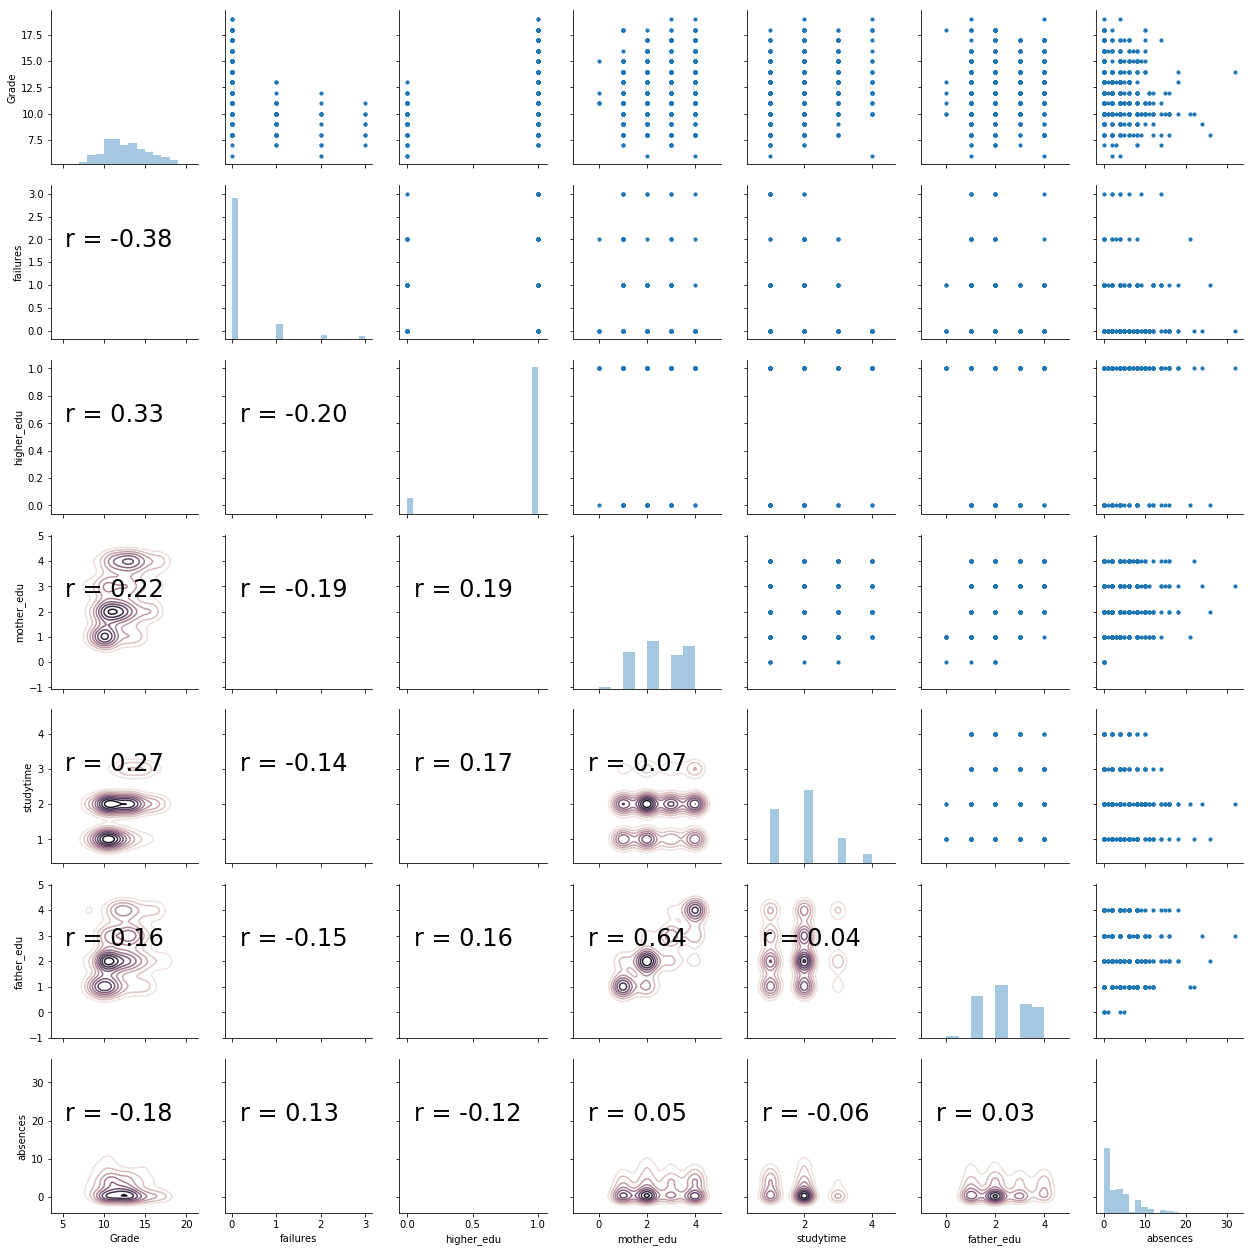

In [31]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [32]:
# Create relation to the median grade column
X_plot = X_train.copy()
X_plot['relation_median'] = (X_plot['Grade'] >= 12)
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='Grade')

### Selected Variables Distribution by Relation to Median

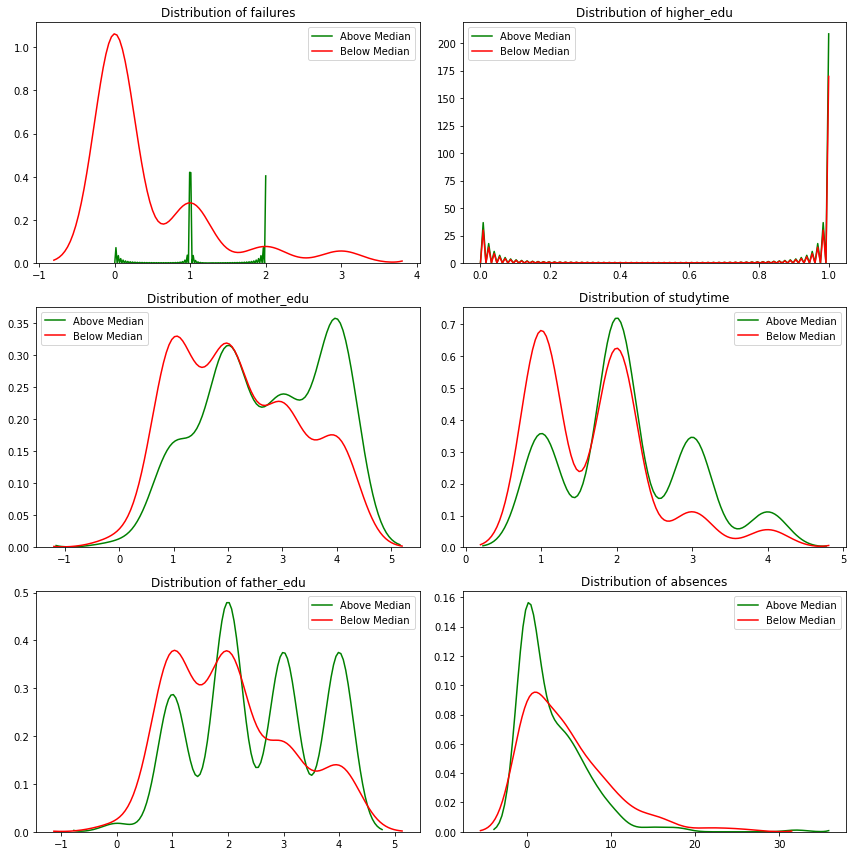

In [33]:
plt.figure(figsize=(12, 12))
# Plot the distribution of each variable colored
# by the relation to the median grade
for i, col in enumerate(X_plot.columns[:-1]):
    plt.subplot(3, 2, i + 1)
    subset_above = X_plot[X_plot['relation_median'] == 'above']
    subset_below = X_plot[X_plot['relation_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

# Establish Benchmarks

## Metrics

For this regression task, we will use two standard metrics:

* Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values
* Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

The mean absolute error is more interpretable, but the root mean squared error penalizes larger errors more heavily. Either one may be appropriate depending on the situation. 
[Here is a discussion](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

In [34]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

### Naive Baseline

For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then perhaps we should try a different approach! 

In [35]:
# Naive baseline is the median
median_pred = X_train['Grade'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['Grade']

In [36]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 2.1761
Median Baseline RMSE: 2.6777


## Standard Machine Learning Models

In [41]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='Grade')
    X_test = X_test.drop(columns='Grade')
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [42]:
results = evaluate(X_train, X_test, y_train, y_test)

#### Visual Comparison of Models

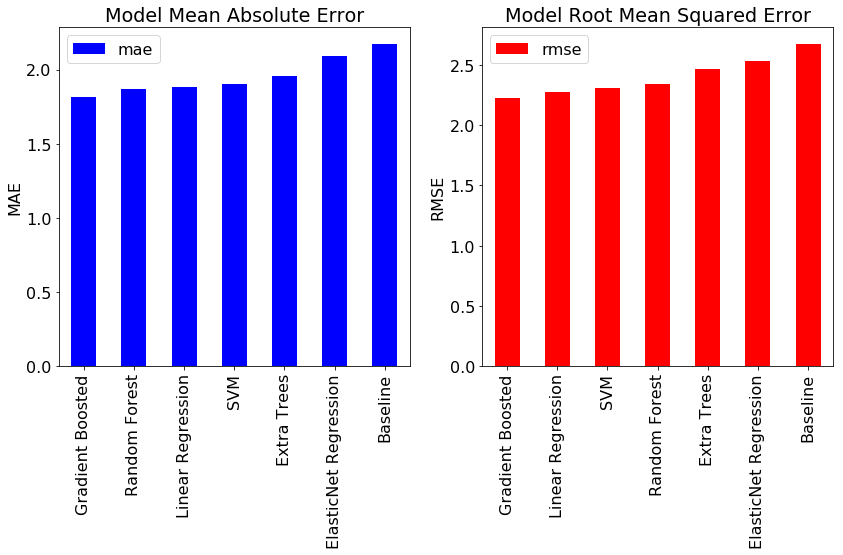

In [43]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [44]:
results

,mae,rmse
Linear Regression,1.8859,2.27395
ElasticNet Regression,2.09282,2.53656
Random Forest,1.86853,2.33975
Extra Trees,1.95494,2.46947
SVM,1.90262,2.30825
Gradient Boosted,1.81272,2.22737
Baseline,2.1761,2.67765


In [45]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 16.70% better than the baseline.


## Formula from Ordinary Least Squares Linear Regression

In [46]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='Grade'), y_train)

ols_formula = 'Grade = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'Grade = 9.19 + -1.32 * failures + 1.86 * higher_edu + 0.26 * mother_edu + 0.58 * studytime + 0.03 * father_edu + -0.07 * absences'

# Implementing Bayesian Linear Regression

In [47]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'Grade ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Grade ~ failures + higher_edu + mother_edu + studytime + father_edu + absences'

## Create Model in PyMC3 and Sample from Posterior

We now build the model using the formula defined above and a normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [48]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, absences, father_edu, studytime, mother_edu, higher_edu, failures, Intercept]
100%|██████████| 2500/2500 [00:08<00:00, 291.36it/s]


# Examine Bayesian Linear Regression Results

## Traceplot of All Samples

In [53]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

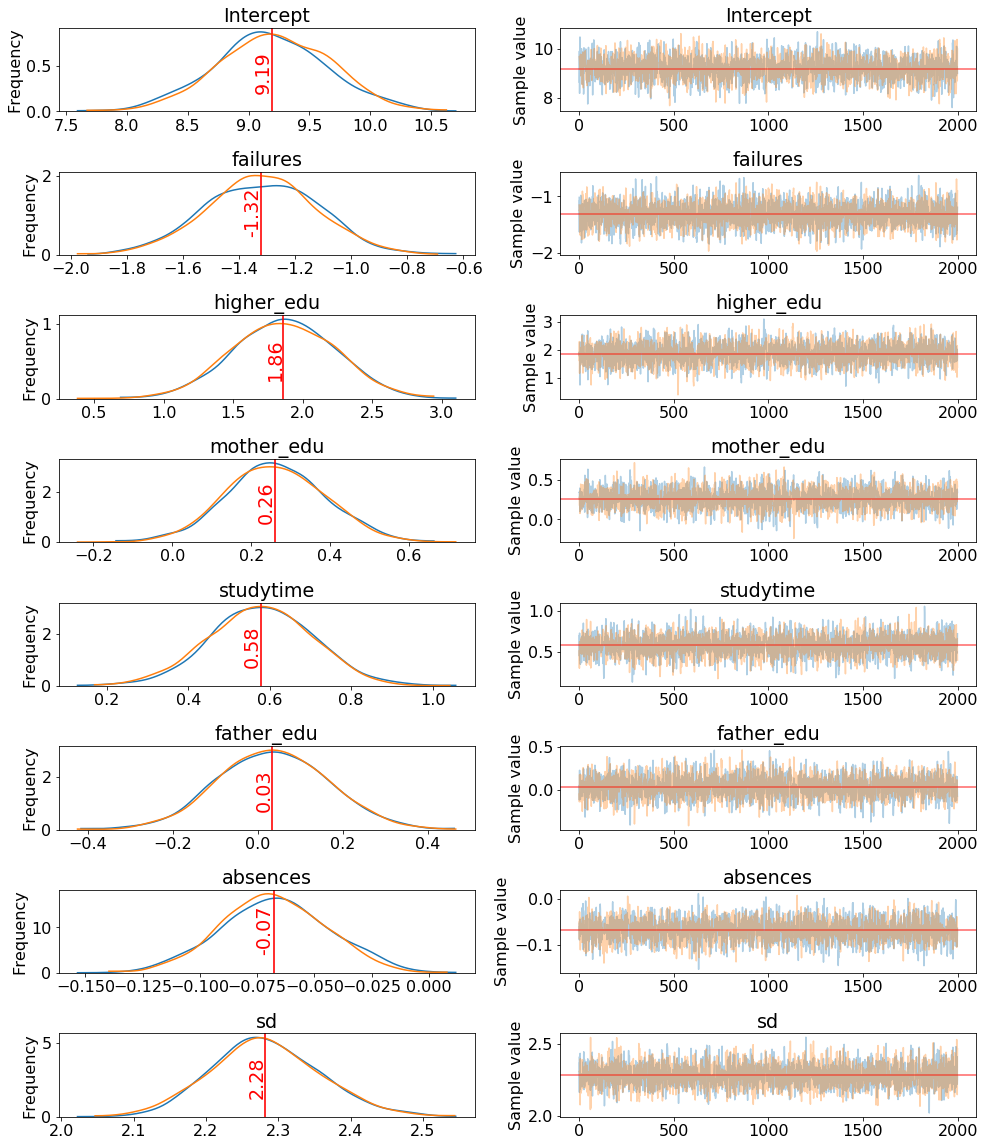

In [54]:
plot_trace(normal_trace);

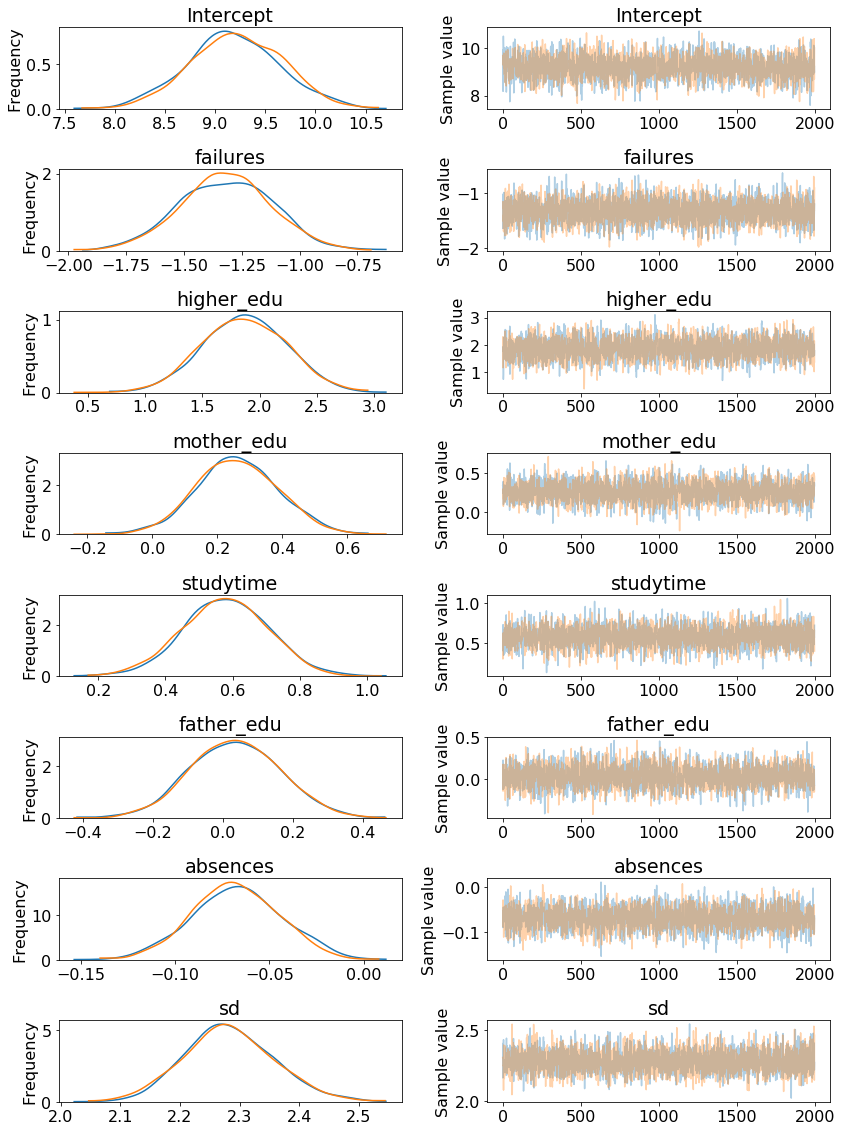

In [55]:
pm.traceplot(normal_trace);

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs. 

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using `pm.forestplot`.

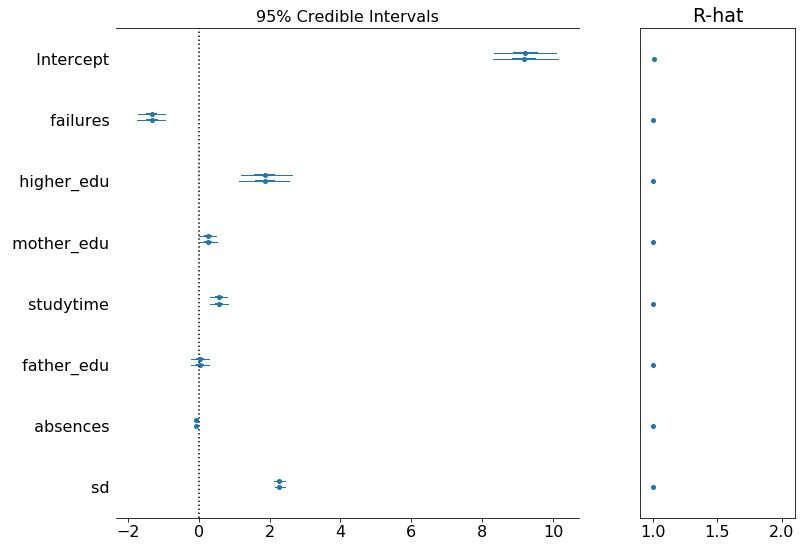

In [56]:
pm.forestplot(normal_trace);

From the forest plot we can see the most likely value of the parameter (the dot) as well as the 95% credible interval for the parameter. The `intercept` and `higher_edu` have larger uncertainty compared to the other variables. 

Another built in plotting method in PyMC3 is the posterior distribution of all the model parameters. These histograms allow us to see how the model result is a distribution for the parameters rather than a single value.

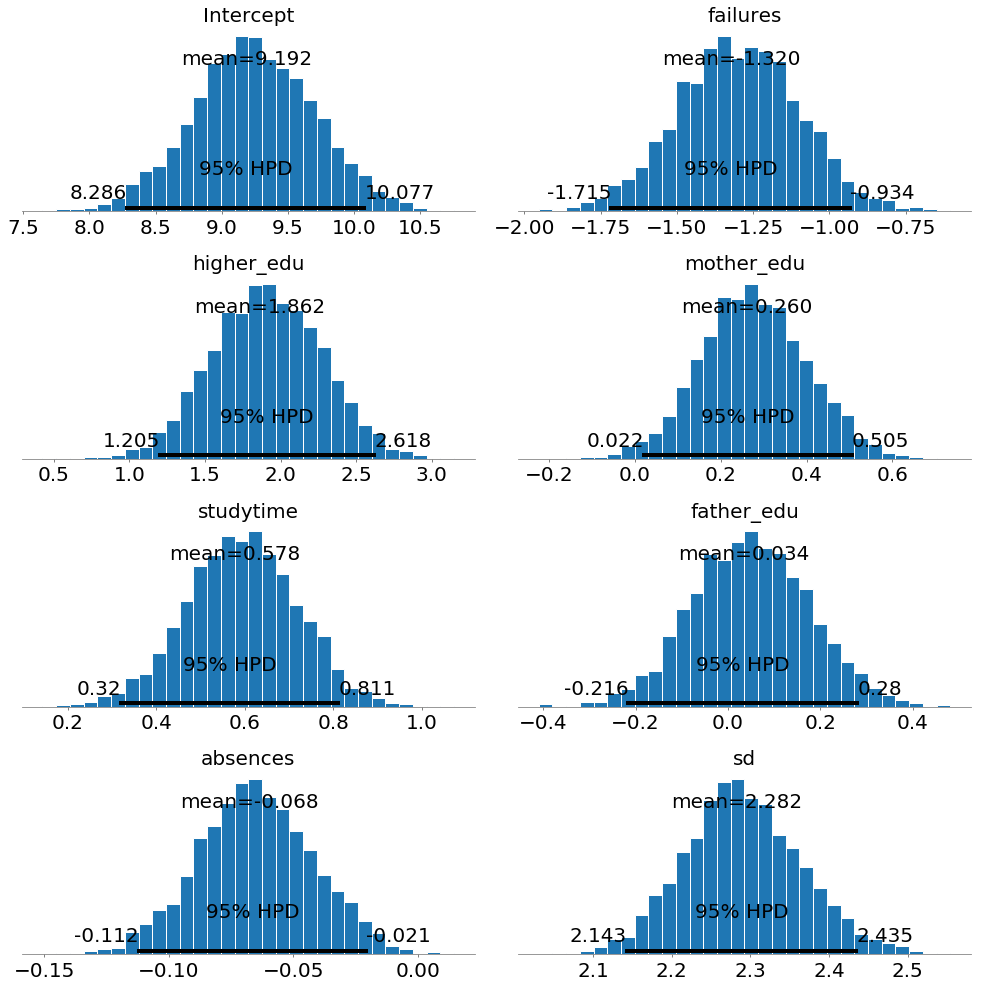

In [57]:
pm.plot_posterior(normal_trace, figsize = (14, 14), text_size=20);

In [58]:
# Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 9.1917
Variable: failures        Mean weight in model: -1.3205
Variable: higher_edu      Mean weight in model: 1.8620
Variable: mother_edu      Mean weight in model: 0.2602
Variable: studytime       Mean weight in model: 0.5775
Variable: father_edu      Mean weight in model: 0.0343
Variable: absences        Mean weight in model: -0.0678
Variable: sd_log__        Mean weight in model: 0.8246
Variable: sd              Mean weight in model: 2.2822


## Interpretations of Weights

Based on the sign and location of the weights, we can make the following inferences regarding the features in our dataset:

* Previous class failures are negatively related to the students final grade
* Higher education ambitions are positively related to the students grade
* The mother's and father's education levels are positively related to the students final grade
* Studying time per week is positively related to the students final grade
* Absences are negatively related to the students final grade

In [60]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,9.191665,0.458124,0.009103,8.286471,10.076789,2229.779289,1.001946
failures,-1.320469,0.200135,0.003110,-1.714610,-0.934060,3566.282419,0.999781
higher_edu,1.861990,0.364494,0.006824,1.204768,2.617633,2685.469769,0.999940
mother_edu,0.260237,0.124379,0.002600,0.022012,0.505250,2736.705356,0.999904
studytime,0.577521,0.126095,0.002199,0.320287,0.810894,2894.144089,1.000755
father_edu,0.034287,0.127300,0.002508,-0.216223,0.279564,2721.300572,0.999825
absences,-0.067818,0.023335,0.000416,-0.111989,-0.020862,3237.328553,1.000417
sd,2.282179,0.074988,0.001159,2.142732,2.434841,4049.481346,0.999942


### Linear Formula from Bayesian Inference using Mean of Parameters

In [61]:
model_formula = 'Grade = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Grade =  9.19 * Intercept + -1.32 * failures + 1.86 * higher_edu + 0.26 * mother_edu + 0.58 * studytime + 0.03 * father_edu + -0.07 * absences + 0.82 * sd_log__ + 2.28 * sd'

## Evaluate Bayesian Model Using Mean of Model Parameters

In [66]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

Model  MAE: 1.8869
Model RMSE: 2.2749


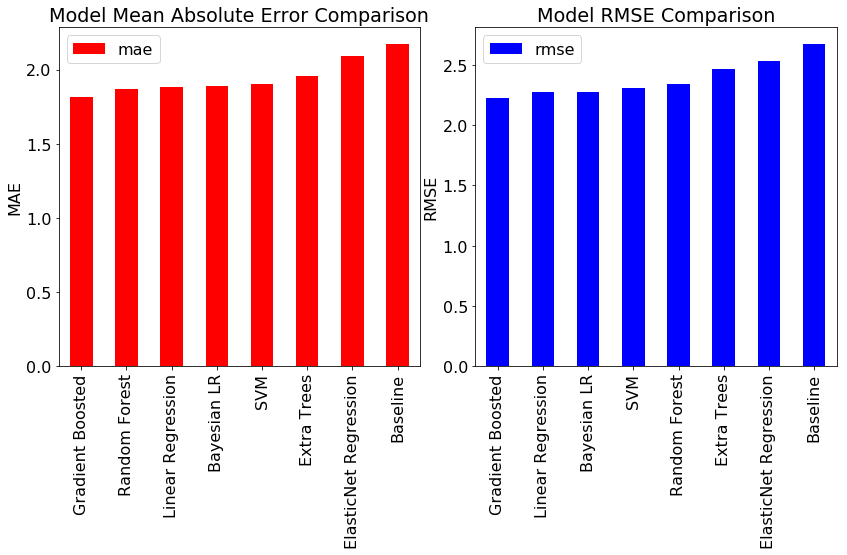

In [67]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)

In [68]:
all_model_results

,mae,rmse
Linear Regression,1.8859,2.27395
ElasticNet Regression,2.09282,2.53656
Random Forest,1.86853,2.33975
Extra Trees,1.95494,2.46947
SVM,1.90262,2.30825
Gradient Boosted,1.81272,2.22737
Baseline,2.1761,2.67765
Bayesian LR,1.88691,2.27494


# Make Predictions from Model

## Test Observations

In [69]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['Grade']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('Grade')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    # Prediction information
    print('True Grade = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
Grade         12
failures       0
higher_edu     1
mother_edu     2
studytime      1
father_edu     2
absences       8
Intercept      1
Name: 39, dtype: int64
True Grade = 12
Average Estimate = 11.6777
5% Estimate = 8.0546    95% Estimate = 15.6862


/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


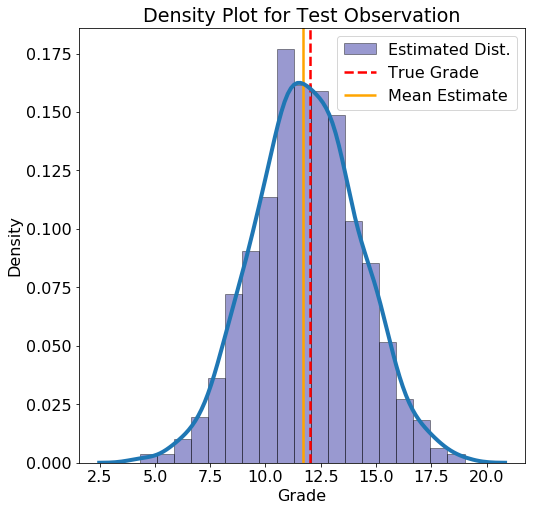

In [70]:
test_model(normal_trace, X_test.iloc[41])

Test Observation:
Grade         12
failures       0
higher_edu     1
mother_edu     1
studytime      2
father_edu     1
absences       6
Intercept      1
Name: 2, dtype: int64
True Grade = 12
Average Estimate = 12.0963
5% Estimate = 8.3571    95% Estimate = 16.0496


/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


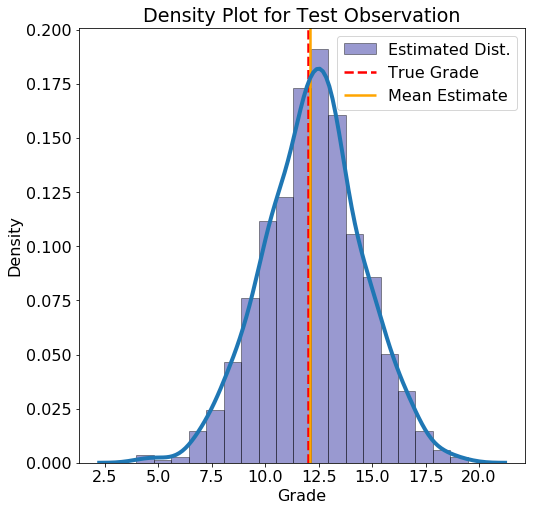

In [71]:
test_model(normal_trace, X_test.iloc[16])

#### Predictions for New Observation

In [72]:
# Make predictions for a new data point from the model trace
def query_model(trace, new_observation):
    
    # Print information about the new observation
    print('New Observation')
    print(new_observation)
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Standard deviation
    sd_value = var_dict['sd'].mean()
    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Align weights and new observation
    var_weights = var_weights[new_observation.index]
    
    # Means of variables
    var_means = var_weights.mean(axis=0)
    
    # Mean for observation
    mean_loc = np.dot(var_means, new_observation)
    
    # Distribution of estimates
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)
    
    # Plot the estimate distribution
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    # Estimate information
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept     1
absences      1
failures      0
father_edu    1
higher_edu    1
mother_edu    4
studytime     3
dtype: int64
Average Estimate = 13.7936
5% Estimate = 9.9270    95% Estimate = 17.6867


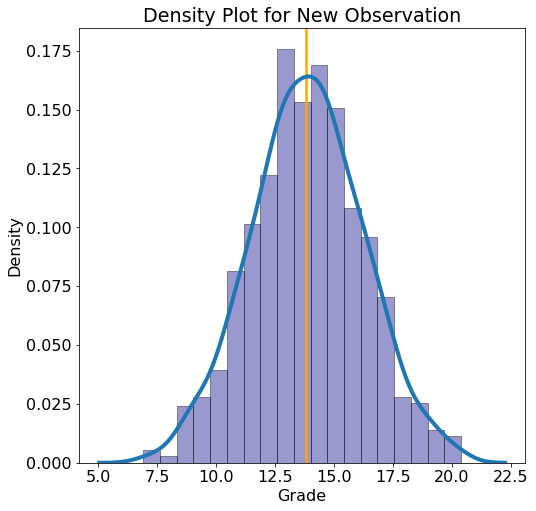

In [73]:
observation = pd.Series({'Intercept': 1, 'mother_edu': 4, 'failures': 0, 
                            'higher_edu': 1, 'studytime': 3,
                            'father_edu': 1, 'absences': 1})
query_model(normal_trace, observation)

New Observation
Intercept     1
absences      4
failures      2
father_edu    3
higher_edu    1
mother_edu    2
studytime     2
dtype: int64
Average Estimate = 9.9198
5% Estimate = 6.2685    95% Estimate = 13.7163


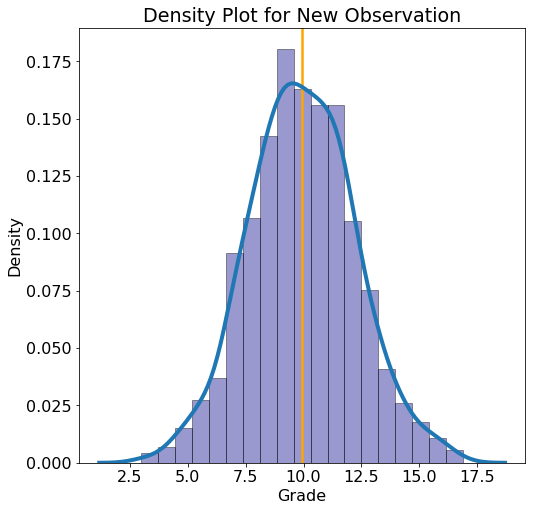

In [74]:
observation = pd.Series({'Intercept': 1, 'mother_edu': 2, 'failures': 2, 
                            'higher_edu': 1, 'studytime': 2,
                            'father_edu': 3, 'absences': 4})
query_model(normal_trace, observation)

# Model Variable Effects

If we want to see the effect of changing one variable while holding the others constant, we can use the function `pm.plot_posterior_predictive_glm`. This takes a range of values to use for the variable, a linear model, and a number of samples. The function evaluates the linear model across the range of values for the number of samples. Each time, it draws a different set of parameters from the trace. This gives us an indication of the effect of a single variable and also the uncertainty in the model estimates. To see the effect of a single variable, we hold the others constant at their median values.

In [75]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    figsize(6, 6)
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Grade', size = 16)
    plt.title("Posterior of Grade vs %s" % query_var, size = 18)
    plt.show()

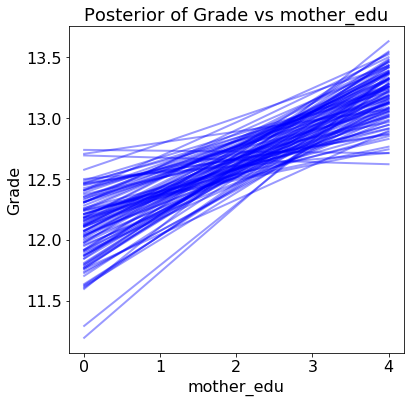

In [76]:
model_effect('mother_edu', normal_trace, X_train.drop(columns='Grade'))

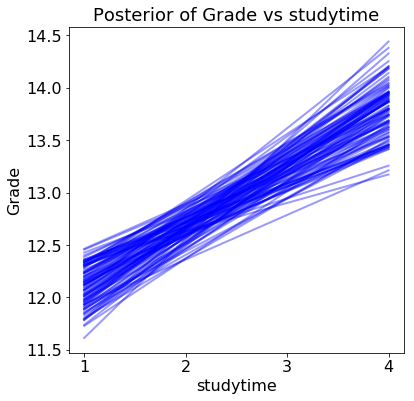

In [77]:
model_effect('studytime', normal_trace, X_train.drop(columns='Grade'))

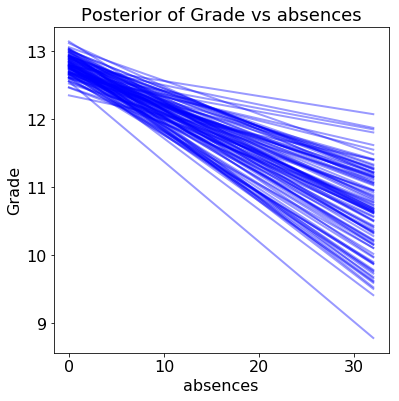

In [78]:
model_effect('absences', normal_trace, X_train.drop(columns='Grade'))

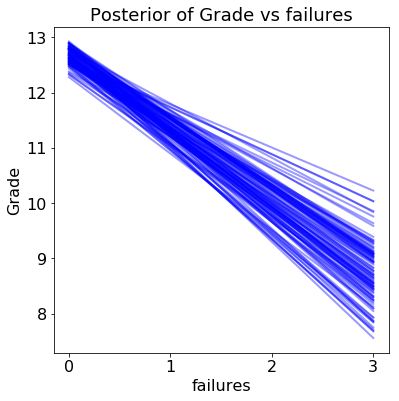

In [79]:
model_effect('failures', normal_trace, X_train.drop(columns='Grade'))

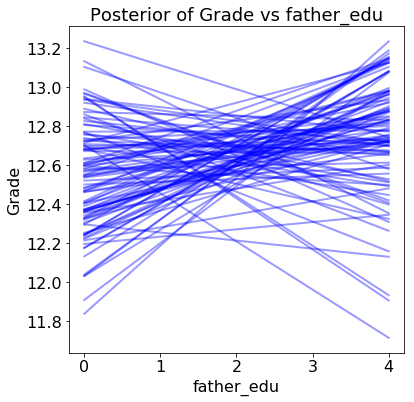

In [80]:
model_effect('father_edu', normal_trace, X_train.drop(columns='Grade'))

# Different Likelihood Prior Distribution

We can perform the exact same Bayesian Linear Modeling using a Student's T-distribution as the prior for the data likelihood. A Student's T Distribution has more weight in the tails of the distribution so it is more robust to outliers. 

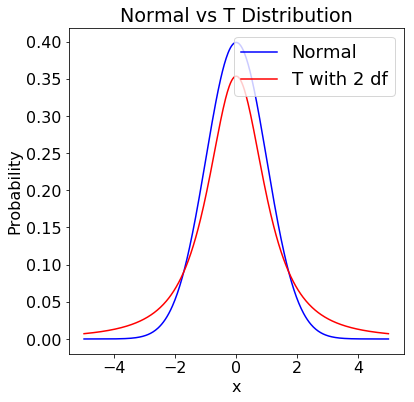

In [81]:
# X values for plotting
x = np.linspace(-5, 5, num = 500)

# Generate pdf of normal distribution
y_norm = scipy.stats.norm.pdf(x)

# PDF of t-distribution with 2 degrees of freedom
y_t = scipy.stats.t.pdf(x, df = 2)

plt.plot(x, y_norm, 'b-', label = 'Normal')
plt.plot(x, y_t, 'r-', label = 'T with 2 df')
plt.legend(prop = {'size': 18}, loc = 1)
plt.xlabel('x'); plt.ylabel('Probability'); plt.title('Normal vs T Distribution');

## Build Model and Perform Inference

In [82]:
# Context for model
with pm.Model() as t_model:
    # Family is Student's T in this case
    family = pm.glm.families.StudentT(df = 2)
    
    # Formula, data, family
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Sample from the posterior 
    t_trace = pm.sample(draws=2000, tune=500, njobs = -1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam_log__, absences, father_edu, studytime, mother_edu, higher_edu, failures, Intercept]
100%|██████████| 2500/2500 [00:08<00:00, 298.52it/s]


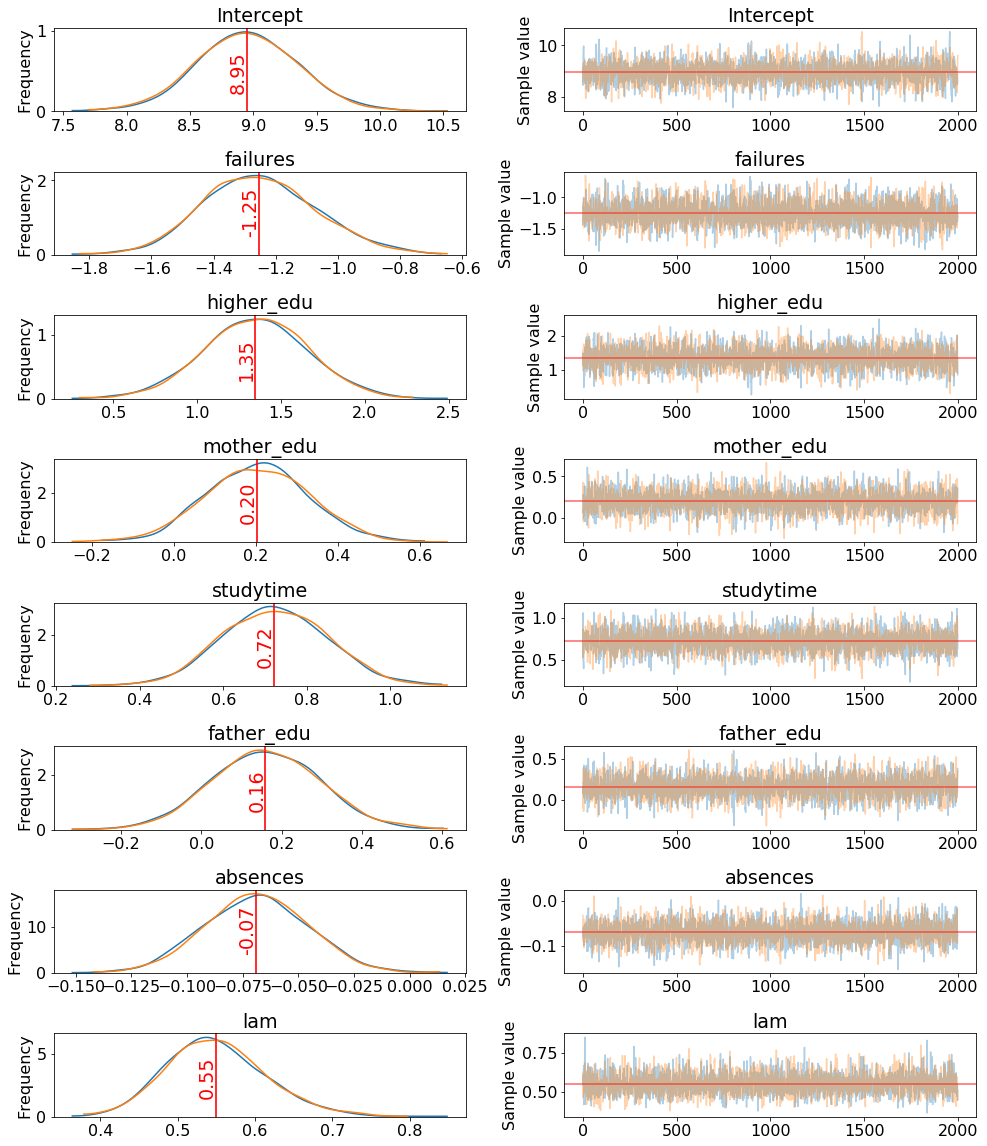

In [83]:
plot_trace(t_trace);

## Test the Model

__I'm not sure I implemented this part correclty!__

In [84]:
def test_model_t(trace, test_observation):
    
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)

    # Actual Value
    actual = test_observation['Grade']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('Grade')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = mean_loc + np.random.standard_t(df = 2, size = 1000)

    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    print('True Grade = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

True Grade = 17
Average Estimate = 12.2538
5% Estimate = 9.3823    95% Estimate = 15.1558


/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


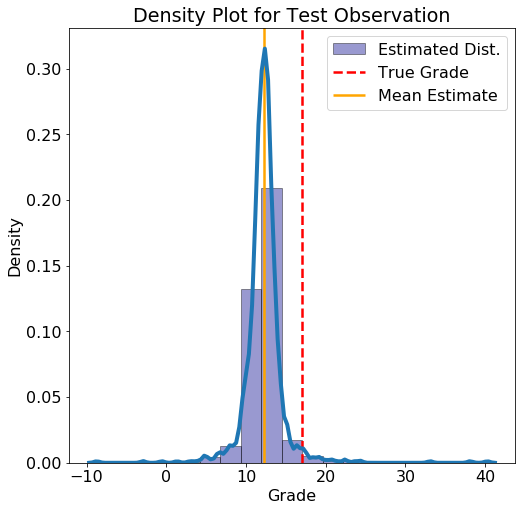

In [85]:
test_model_t(t_trace, X_test.iloc[60])

Test Observation:
Grade         17
failures       0
higher_edu     1
mother_edu     4
studytime      1
father_edu     4
absences       3
Intercept      1
Name: 595, dtype: int64
True Grade = 17
Average Estimate = 12.6058
5% Estimate = 8.9236    95% Estimate = 16.3146


/home/jfelipe/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


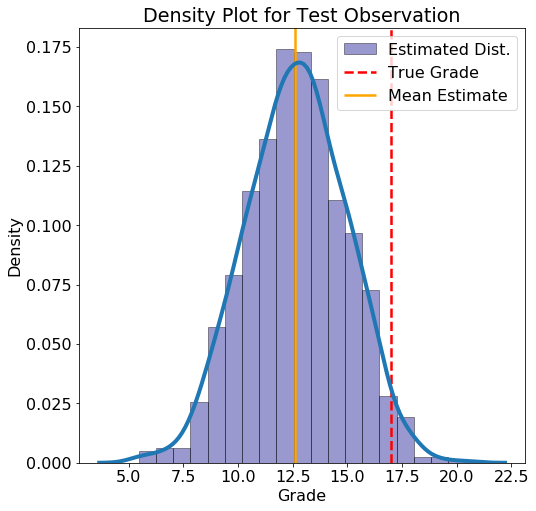

In [86]:
test_model(normal_trace, X_test.iloc[60])

## New Observation Predictions

__I'm not sure about these predictions!__

In [87]:
def query_model_t(trace, new_observation):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        

    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Align weights and new observation
    var_weights = var_weights[new_observation.index]
    # Means of variables
    var_means = var_weights.mean(axis=0)
    
    # Mean for observation
    mean_loc = np.dot(var_means, new_observation)
    
    # Distribution of estimates
    estimates = mean_loc +  np.random.standard_t(df = 2, size = 1000)
    

    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept     1
absences      1
failures      0
father_edu    1
higher_edu    1
mother_edu    4
studytime     3
dtype: int64
Average Estimate = 13.7936
5% Estimate = 9.9411    95% Estimate = 17.4109


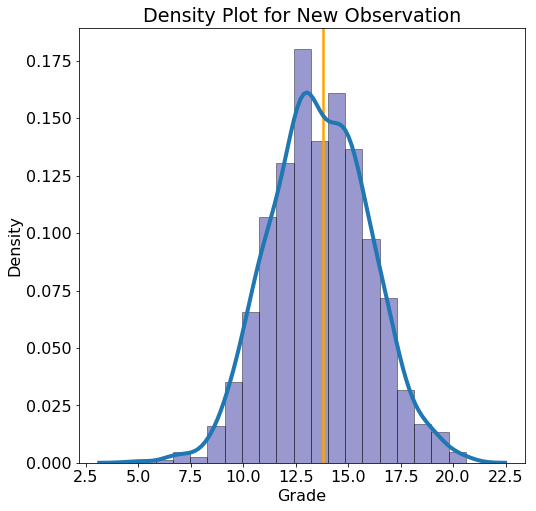

In [88]:
observation = pd.Series({'Intercept': 1, 'mother_edu': 4, 'failures': 0, 
                            'higher_edu': 1, 'studytime': 3,
                            'father_edu': 1, 'absences': 1})
query_model(normal_trace, observation)

Average Estimate = 13.3564
5% Estimate = 10.1703    95% Estimate = 16.0306


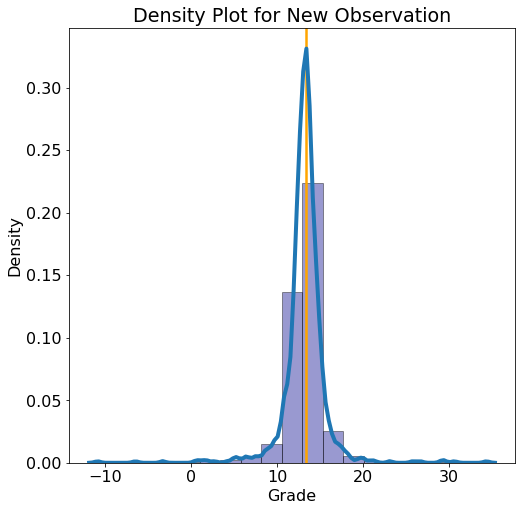

In [89]:
observation = pd.Series({'Intercept': 1, 'mother_edu': 4, 'failures': 0, 
                            'higher_edu': 1, 'studytime': 3,
                            'father_edu': 1, 'absences': 1})
query_model_t(t_trace, observation)

There is some variation between the t-distribution estimates and those from the normal distribution for the data likelihood.Choosing appropriate priors is one of the hardest aspect of Bayesian Modeling, but we can get around that by having more data. As the amount of data the model learns from increases, the prior has less of an effect because each time the posterior is updated based on the new data. Essentially machine learning models perform inference with no priors, basing the final model entirely on the data. In the case of limited samples, Bayesian Inference can be a better method for building models because it provides a reasonable estimate in situations with few data points (as long as the prior is reasonable).

# Conclusions

In this notebook we looked at using Bayesian Linear Regression to predict student performance based on six factors. Rather than specify probabilities for the Bayesian network which is basically impossible for continuous variables, we framed the problem as a machine learning task. In addition to the standard machine learning models that learn from observations, we also used Bayesian Linear Regression to create a model mapping the features (student characteristics) to the targets (final grade). The advantages of Bayesian Linear Regression are that if we use sensible priors, we can still get a decent estimate with few samples, and the final weights are not a single number, but a distribution componsed of every sample drawn during the sampling run. We can then make predictions using all the sampled weights to form a distribution of expected values rather than a single answer. 

The Bayesian  Linear Regression did not perform as well as the other methods in terms of the two metrics we choose. This might not be the ideal case for a Bayesian inference approach but we saw that Bayesian Linear Regression produced intuitive estimates for the model weights and gave predictions for new students that align with our expectations for the factors influencing student performance. To summarize, although Bayesian Linear Regression did not outperform the standard machine learning methods, it gave us a chance to learn another tool for use in evaluating and making sense of data. It's always a positive to have more skills that you can deploy as needed!